In [530]:
import json 
import numpy as np
import geopandas as gpd

from shapely import wkt
from shapely.geometry import Polygon,LineString

# Functions

### FOR SESA:
replace line 56 in `def xbd2gdf(f_in):` with the following `return {'angle': a, 'longest_segment': longest_segment.length/2, 'shortest_segment': shortest_segment.length/2}`


replace the `rasterize_poly` func

In [545]:
def xbd2gdf(f_in):
    """
    Convert an xBD json vector file to a geo-dataframe and calculates
    the angle, major, and minor axis of the minimum oriented bounding box
    of each polygon in the file.

    Args:
        f_in (str): The path to the xBD json file

    Returns:
        gdf (geopandas.GeoDataFrame): The geo-dataframe containing the polygons
        (with the uid, damage, and geometry columns from the xBD json file)
        and the calculated **angle, major, and minor axis** of the minimum oriented
        bounding box of each polygon.
    """

    # adapted from https://github.com/DIUx-xView/xView2_baseline/blob/master/utils/view_polygons.ipynb
    with open(f_in, 'rb') as image_json_file:
        image_json = json.load(image_json_file)

    # coords can be in xy or in lng_lat format 
    coords = image_json['features']['lng_lat']
    wkt_polygons = []

    for coord in coords:
        if 'subtype' in coord['properties']:
            damage = coord['properties']['subtype']
        else:
            damage = 'no-damage'

        uid = coord['properties']['uid']
        wkt_polygons.append((uid, damage, coord['wkt']))

    polygons = []

    for uid, damage, swkt in wkt_polygons:
        polygons.append((uid, damage, wkt.loads(swkt)))

    # adapted from https://gis.stackexchange.com/questions/380499/calculate-azimuth-from-polygon-in-geopandas
    def get_angle(poly, mode='degrees'):
        # g = poly.geometry
        a = poly.minimum_rotated_rectangle
        l = a.boundary
        coords = [c for c in l.coords]
        segments = [LineString([a, b]) for a, b in zip(coords,coords[1:])]
        longest_segment = max(segments, key=lambda x: x.length)
        shortest_segment = min(segments, key=lambda x: x.length)
        p1, p2 = [c for c in longest_segment.coords]

        if mode=='degrees':
            a = np.degrees(np.arctan2(p2[1]-p1[1], p2[0]-p1[0]))
        else:
            a = np.arctan2(p2[1]-p1[1], p2[0]-p1[0])

        # REPLACE THIS LINE
        return {'angle': a, 'longest_segment': longest_segment.length/2, 'shortest_segment': shortest_segment.length/2}
        
    gdf = gpd.GeoDataFrame(polygons, columns=['uid', 'damage', 'geometry'], geometry='geometry', crs='EPSG:4326')
    gdf = gdf.to_crs('EPSG:3395')
    gdf[['angle','major', 'minor']] = gdf.apply(lambda x: get_angle(x.geometry, mode='radians'), axis=1, result_type='expand')

    return gdf

def rasterize_poly(gdf, crs='EPSG:3395', px=128, gsd=0.5):
    from rasterio.features import rasterize
    from rasterio.transform import from_bounds
    """
    Rasterize the polygons in the geo-dataframe

    Args:
        gdf (geopandas.GeoDataFrame): The geo-dataframe containing the polygons
        crs (str): The coordinate reference system of the polygons
        px (int): The number of pixels in the raster
        gsd (float): The ground sample distance of the raster (in map units) i.e. the size of the pixel in linear map units

    Returns:
        raster (numpy.ndarray): The rasterized polygons
    """
    gdf = gdf.to_crs(crs)

    xy = gdf.geometry.centroid
    x, y = xy.x.item(), xy.y.item()
    
    r = gsd*px/2
    xmin, ymin, xmax, ymax = x-r, y-r, x+r, y+r

    # shapes = [(poly, 1) for poly in gdf.geometry]
    # shapes = [(gdf.geometry.item(), 1)]
    transform = from_bounds(xmin, ymin, xmax, ymax, px, px)
    
    raster = rasterize([(gdf.geometry.item(), 1),], out_shape=(px, px), fill=0, all_touched=True, transform=transform)
    return raster, transform

def draw_ellipsoid(c, M, m, a):
    """
    Draw an ellipsoid

    Args:
        c (tuple): The center of the ellipsoid
        M (float): The major axis of the ellipsoid
        m (float): The minor axis of the ellipsoid
        a (float): The angle of the ellipsoid

    Returns:
        ellipsoid (shapely.geometry.Polygon): The ellipsoid
    """
    from shapely.geometry import Polygon

    t = np.linspace(0, 2*np.pi, 100)
    x = c[0] + M*np.cos(t)*np.cos(a) - m*np.sin(t)*np.sin(a)
    y = c[1] + M*np.cos(t)*np.sin(a) + m*np.sin(t)*np.cos(a)
    ellipsoid = Polygon(zip(x, y))
    return ellipsoid

def poly2density(gdf, kernel, px=128, mode='centroid'):
    ''' 
    Calculate the kernel density of the polygons in a geo-dataframe.
    '''

    from scipy.signal import convolve2d
    from rasterio.transform import from_bounds

    if mode not in ['centroid', 'poly', 'ellipsoid']:
        raise ValueError('mode must be "centroid", "poly", or "ellipsoid"')
    
    

    if mode == 'centroid':
        xy = gdf.geometry.centroid
        x, y = xy.x, xy.y

        empty_grid = np.zeros((px,px))
        i = int(px/2)
        xmin, ymin, xmax, ymax = x-i, y-i, x+i, y+i

        empty_grid[i, i] = 1
        empty_grid[i-1, i] = 1
        empty_grid[i-1, i-1] = 1
        empty_grid[i, i-1] = 1
        
        r = empty_grid
        t = from_bounds(xmin, ymin, xmax, ymax, px, px)

    
    if mode == 'poly':
        # next line may be necessary if gdf is a pandas.Series object
        # g = gpd.GeoDataFrame([gdf.iloc[i]], columns=gdf.columns, geometry='geometry', crs='crs')
        r, t = rasterize_poly(gdf, px=px)

    if mode == 'ellipsoid':

        a, M, m = gdf.angle.item(), gdf.major.item(), gdf.minor.item()

        xy = gdf.geometry.centroid
        x, y = xy.x.item(), xy.y.item()

        # a, M, m = gdf.angle, gdf.major.length/2, gdf.minor.length/2
        # a, M, m = gdf.angle.item(), gdf.major.item().length/2, gdf.minor.item().length/2

        # xy = gdf.geometry.centroid
        # x, y = xy.x.item(), xy.y.item()
        
        e = draw_ellipsoid((x,y), M, m, a)
        r, t = rasterize_poly(gpd.GeoDataFrame({'geometry': [e]}, crs=gdf.crs), px=px)
        
    r = convolve2d(r, kernel, mode='same', boundary='fill', fillvalue=0)
        
    return r, t

def io_wrap(name, r, _, target='./temp'):
    from PIL import Image

    im = Image.fromarray(r)
    im = im.convert('L')
    im.save(f"{target}/{name}.png")

## Kernel implementations

In [532]:
# Kernel functions. Can be customized with different functions
# check https://en.wikipedia.org/wiki/Kernel_(statistics)

def gaussianKernel(x):
    return np.divide(1, 1*np.sqrt(2*np.pi))*np.exp(-0.5*(np.divide(x, 1))**2)

def epanechnikovKernel(x):
    return np.where(np.abs(x) <= 1, np.divide(3, 4*1)*(1-np.divide(x, 1)**2), 0)
     

def tricubeKernel(x):
    return np.divide(70, 81)*np.power(1-np.abs(np.power(x,3)),3)


def generate_kernel(r, f, limit=1):
    """
    Generate a 2D kernel for a kernel density estimation

    Args:
        r (int): The resolution of the kernel
        f (function): The kernel function
        limit (float): The domain of the kernel function (x,y) most kernels are defined in the range [-1,1] only. Adjust r to change the size of the filter.

    Returns:
        xx*yy (numpy.ndarray): The 2D kernel
    """
    x, y = np.linspace(-limit, limit, r), np.linspace(-limit, limit, r)
    # x, y = np.arange(m-r, m+r+1, 1), np.arange(m-r, m+r+1, 1)

    xx, yy = f(np.meshgrid(x, y))
    return xx*yy
    


# Run

In [533]:
f_in = './data/woolsey-fire_00000645_post_disaster.json'
gdf = xbd2gdf(f_in)
gdf = gdf.to_crs('EPSG:3395')

In [534]:
# shape = 31
# g = gpd.GeoDataFrame([gdf.iloc[shape]], columns=gdf.columns, geometry='geometry', crs='EPSG:3395')

# a, M, m = g.angle.item(), g.major.item(), g.minor.item()

# xy = g.geometry.centroid
# x, y = xy.x.item(), xy.y.item()

# e = draw_ellipsoid((x,y), M, m, a)
# g.geometry.plot()

# from rasterio.features import rasterize
# from rasterio.transform import from_bounds
# px =128
# xy = g.geometry.centroid
# x, y = xy.x.item(), xy.y.item()
# xmin, ymin, xmax, ymax = x-px/2, y-px/2, x+px/2, y+px/2
# t=from_bounds(xmin, ymin, xmax, ymax, px, px)
# rg = rasterize([(g.geometry.item(), 1),], out_shape=(px,px), fill=0, all_touched=True, transform=t)
# rg = rasterize_poly(g, px=128)

# import matplotlib.pyplot as plt
# plt.imshow(rg[0])

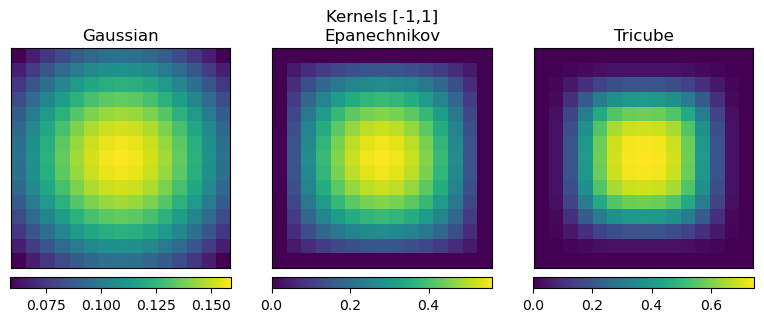

In [535]:
# plot kernels 
import matplotlib.pyplot as plt

gk = generate_kernel(15,gaussianKernel)
ek = generate_kernel(15,epanechnikovKernel)
tk = generate_kernel(15,tricubeKernel)

fig, ax = plt.subplots(1,3, figsize=(8,3), sharex=True, sharey=True)
ax[0].imshow(gk)
ax[0].set_title('Gaussian') 
ax[1].imshow(ek)
ax[1].set_title('Epanechnikov')
ax[2].imshow(tk)
ax[2].set_title('Tricube')

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

fig.suptitle('Kernels [-1,1]')
fig.tight_layout()

fig.colorbar(ax[0].imshow(gk), ax=ax[0], orientation='horizontal', fraction=0.046, pad=0.04)
fig.colorbar(ax[1].imshow(ek), ax=ax[1], orientation='horizontal', fraction=0.046, pad=0.04)
fig.colorbar(ax[2].imshow(tk), ax=ax[2], orientation='horizontal', fraction=0.046, pad=0.04)



Text(0.5, 0.98, 'Kernels [-1,1], 3D view\nsampled at 99 points for demonstration purposes')

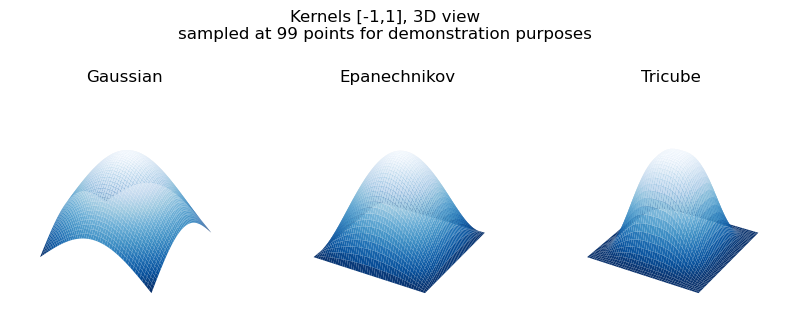

In [536]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,4), subplot_kw={"projection": "3d"})

xx, yy = np.linspace(-1, 1, 99), np.linspace(-1, 1, 99)
X, Y = np.meshgrid(xx, yy)

Z_g = generate_kernel(99,gaussianKernel)
Z_e = generate_kernel(99,epanechnikovKernel)
Z_t = generate_kernel(99,tricubeKernel)

ax1.plot_surface(X, Y, Z_g, cmap='Blues_r', edgecolor='none')
ax1.set_title('Gaussian')
ax2.plot_surface(X, Y, Z_e, cmap='Blues_r', edgecolor='none')
ax2.set_title('Epanechnikov')
ax3.plot_surface(X, Y, Z_t, cmap='Blues_r', edgecolor='none')
ax3.set_title('Tricube')



ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

fig.suptitle('Kernels [-1,1], 3D view\nsampled at 99 points for demonstration purposes')

In [537]:
# Export the geo-dataframe to a geopackage (must remove major and minor axis because lineString is not supported by geopackage)
# gdf_sub = gdf[['uid', 'damage', 'geometry', 'angle']]
# gdf_sub.to_file('/Users/ruben/Library/CloudStorage/OneDrive-国立大学法人東北大学/RESEARCH/0010_DL_EXPERIMENTS/data/woolsey-fire_00000645_post_disaster.gpkg', driver='GPKG')

## Plots

In [538]:
shapes =[31, 13, 2, 26, 29]
gdf_sub = gdf.iloc[shapes]

Text(0.5, 0.95, 'Centroid based density using different kernels (|x| = |y|=32m (128px))')

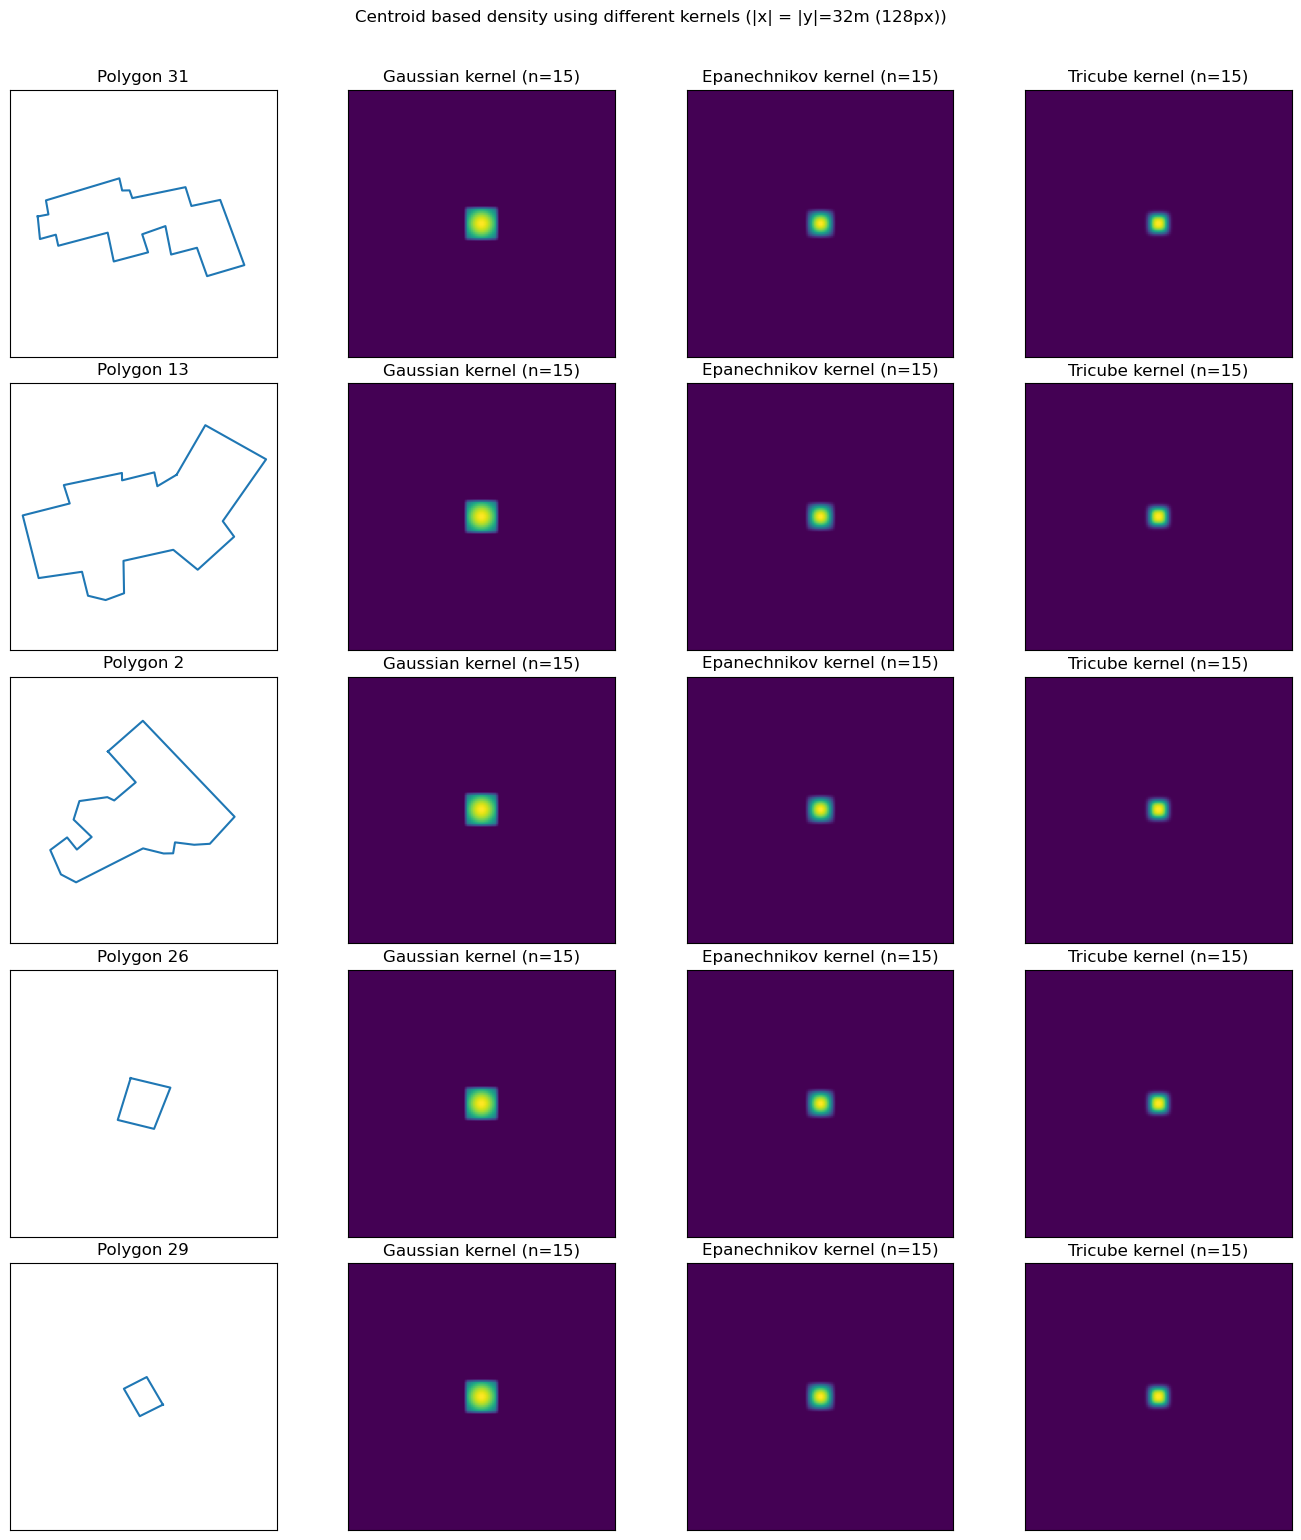

In [539]:
fig, ax = plt.subplots(5,4, figsize=(13.5,16))
for i, (bid, shape) in enumerate(gdf_sub.iterrows()):

    # print(type(shape.geometry))
    
    x,y = shape.geometry.exterior.xy
    
    c = shape.geometry.centroid
    x = np.array(x) - c.x
    y = np.array(y) - c.y
    ax[i,0].plot(x,y)   
    ax[i,0].set_title(f'Polygon {bid}')

    ax[i,0].set_xlim(-32,32)
    ax[i,0].set_ylim(-32,32)
    ax[i,0].set_aspect('equal')

    r, t = poly2density(shape, gk, px=128, mode='centroid')
    ax[i,1].imshow(r)
    ax[i,1].set_title('Gaussian kernel (n=15)')

    r, t = poly2density(shape, ek, px=128, mode='centroid')
    ax[i,2].imshow(r)
    ax[i,2].set_title('Epanechnikov kernel (n=15)')

    r, t = poly2density(shape, tk, px=128, mode='centroid')
    ax[i,3].imshow(r)
    ax[i,3].set_title('Tricube kernel (n=15)')

    for a in ax[i]:
        a.set_xticks([])
        a.set_yticks([])

# fig.tight_layout()
    fig.subplots_adjust(left=.0, right=1.0, bottom=.0,top=0.9, wspace=0.01, hspace=0.1)
fig.suptitle('Centroid based density using different kernels (|x| = |y|=32m (128px))', x=0.5, y=0.95, )
    

Text(0.5, 0.95, 'Polygon distribution of 5 polygons using different kernels (|x| = |y|=32m (128px))')

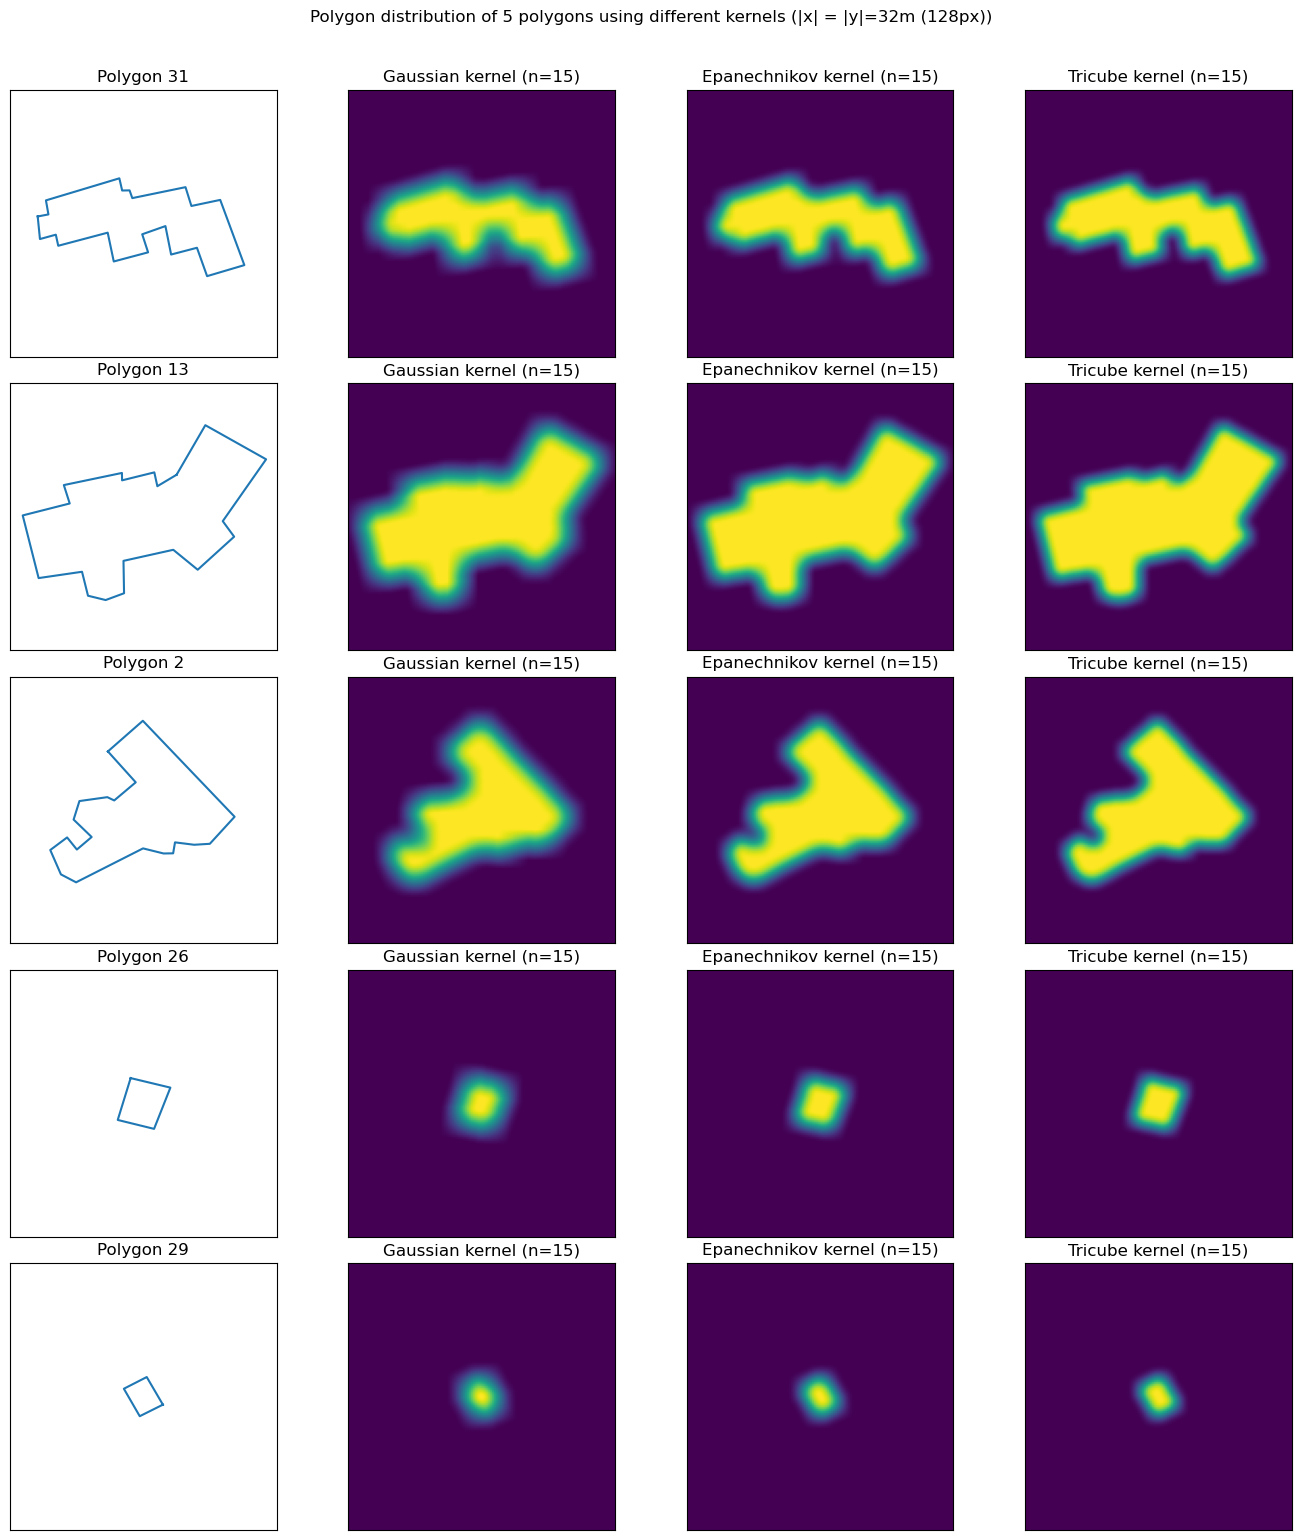

In [540]:

fig, ax = plt.subplots(5,4, figsize=(13.5,16))
for i, (bid, shape) in enumerate(gdf_sub.iterrows()):

    # print(type(shape.geometry))
    x,y = shape.geometry.exterior.xy
    c = shape.geometry.centroid
    x = np.array(x) - c.x
    y = np.array(y) - c.y
    ax[i,0].plot(x,y)   
    ax[i,0].set_title(f'Polygon {bid}')

    ax[i,0].set_xlim(-32,32)
    ax[i,0].set_ylim(-32,32)
    ax[i,0].set_aspect('equal')

    shape = gpd.GeoDataFrame([shape], columns=gdf.columns, geometry='geometry', crs='EPSG:3395')

    r, t = poly2density(shape, gk, px=128, mode='poly')
    ax[i,1].imshow(r)
    ax[i,1].set_title('Gaussian kernel (n=15)')

    r, t = poly2density(shape, ek, px=128, mode='poly')
    ax[i,2].imshow(r)
    ax[i,2].set_title('Epanechnikov kernel (n=15)')

    r, t = poly2density(shape, tk, px=128, mode='poly')
    ax[i,3].imshow(r)
    ax[i,3].set_title('Tricube kernel (n=15)')

    for a in ax[i]:
        a.set_xticks([])
        a.set_yticks([])

# fig.tight_layout()
    fig.subplots_adjust(left=.0, right=1.0, bottom=.0,top=0.9, wspace=0.01, hspace=0.1)
fig.suptitle('Polygon distribution of 5 polygons using different kernels (|x| = |y|=32m (128px))', x=0.5, y=0.95, )

Text(0.5, 0.95, 'Density about an ellipsoid based on the minimum rotated bounding area using different kernels (|x| = |y|=32m (128px))')

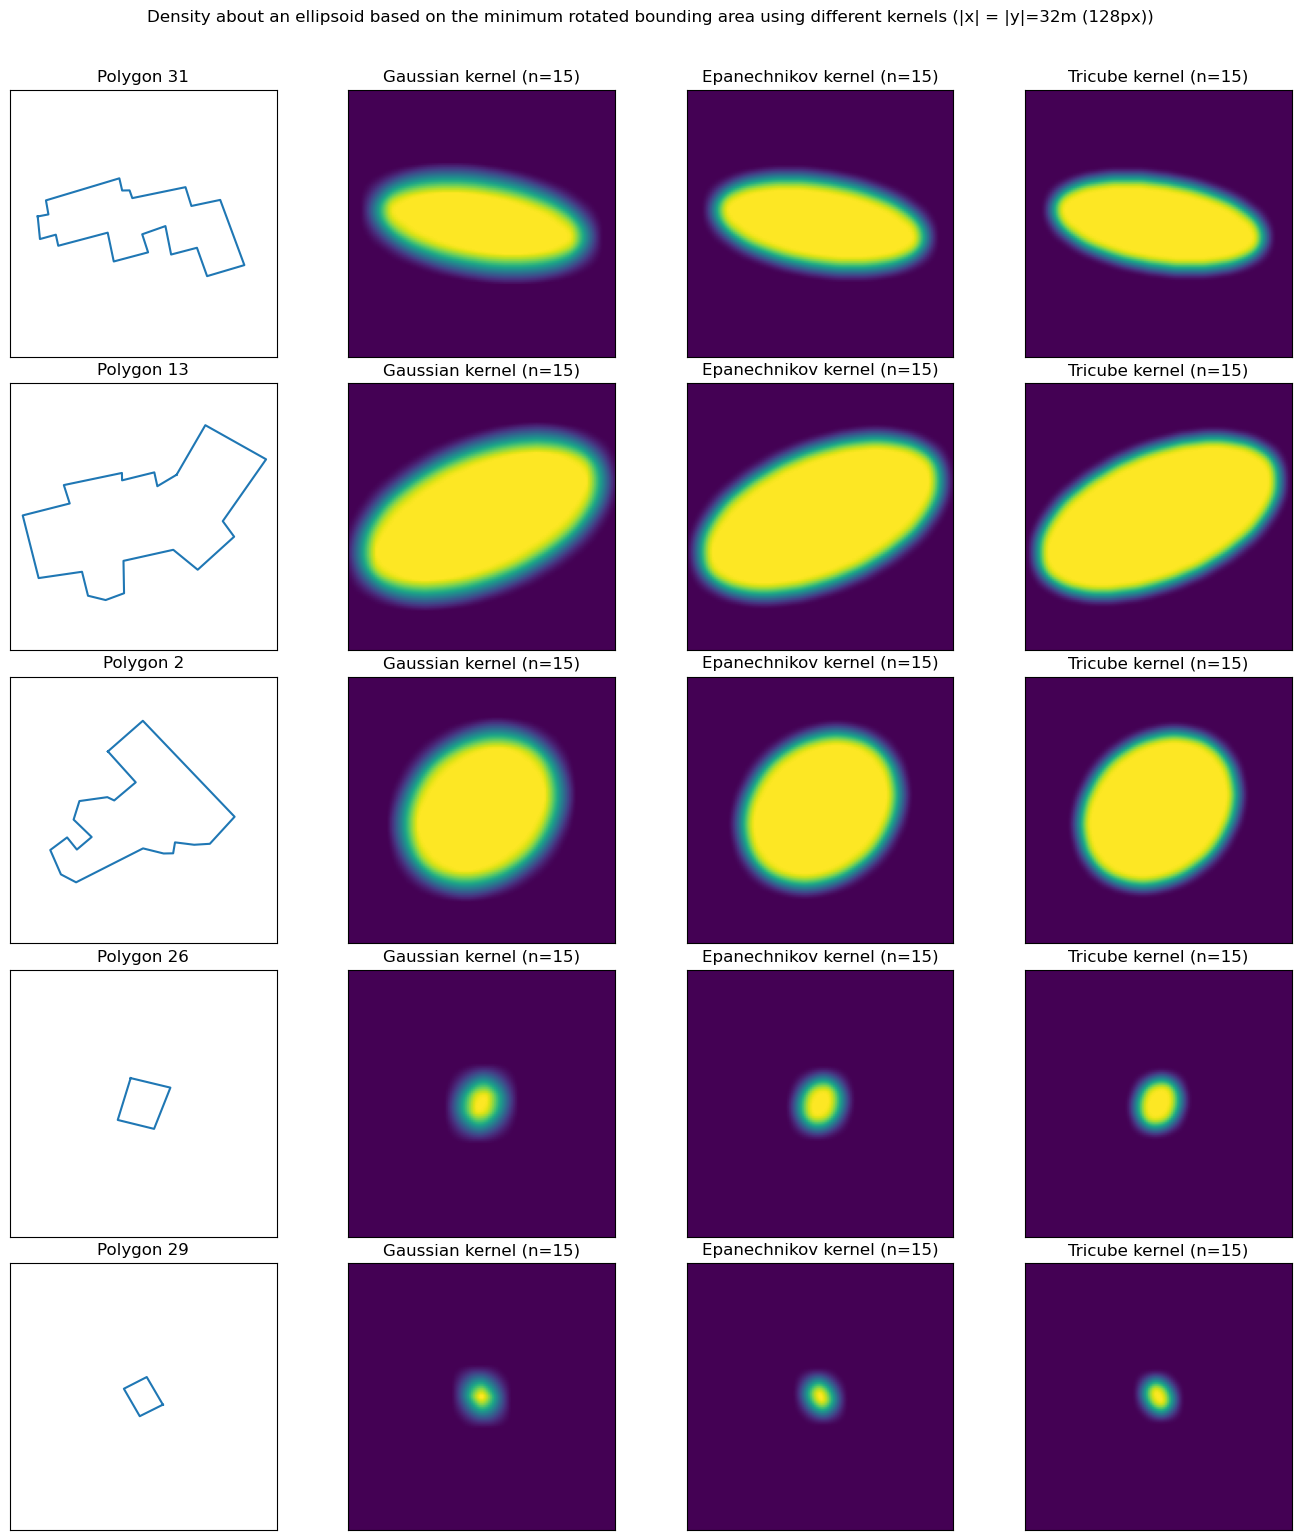

In [541]:

fig, ax = plt.subplots(5,4, figsize=(13.5,16))
for i, (bid, shape) in enumerate(gdf_sub.iterrows()):

    # print(type(shape.geometry))
    x,y = shape.geometry.exterior.xy
    c = shape.geometry.centroid
    x = np.array(x) - c.x
    y = np.array(y) - c.y
    ax[i,0].plot(x,y)   
    ax[i,0].set_title(f'Polygon {bid}')

    ax[i,0].set_xlim(-32,32)
    ax[i,0].set_ylim(-32,32)
    ax[i,0].set_aspect('equal')

    shape = gpd.GeoDataFrame([shape], columns=gdf.columns, geometry='geometry', crs='EPSG:3395')
    

    r, t = poly2density(shape, gk, px=128, mode='ellipsoid')
    ax[i,1].imshow(r)
    ax[i,1].set_title('Gaussian kernel (n=15)')

    r, t = poly2density(shape, ek, px=128, mode='ellipsoid')
    ax[i,2].imshow(r)
    ax[i,2].set_title('Epanechnikov kernel (n=15)')

    r, t = poly2density(shape, tk, px=128, mode='ellipsoid')
    ax[i,3].imshow(r)
    ax[i,3].set_title('Tricube kernel (n=15)')

    for a in ax[i]:
        a.set_xticks([])
        a.set_yticks([])

# fig.tight_layout()
    fig.subplots_adjust(left=.0, right=1.0, bottom=.0,top=0.9, wspace=0.01, hspace=0.1)
fig.suptitle('Density about an ellipsoid based on the minimum rotated bounding area using different kernels (|x| = |y|=32m (128px))', x=0.5, y=0.95, )

In [550]:
#vectorized dataset creation
import os

data_pth = '/Users/ruben/Library/CloudStorage/OneDrive-国立大学法人東北大学/RESEARCH/0010_DL_EXPERIMENTS/data/woolsey-fire_00000645_post_disaster.json'
gdf = xbd2gdf(data_pth)
gdf = gdf.to_crs('EPSG:3395')

gk = generate_kernel(15,gaussianKernel)
ek = generate_kernel(15,epanechnikovKernel)
tk = generate_kernel(15,tricubeKernel)

os.makedirs('./temp', exist_ok=True)
gdf.apply(lambda x: io_wrap(x.uid, *poly2density(x, gk, px=128, mode='poly')), axis=1)

AttributeError: 'Series' object has no attribute 'to_crs'